# RESEARCH QUESTION: Consumption forecasting.
We can use the weather forecast for the same day, but consumnption forecasting stops 5 days in advance.
It is said that the forecase is made at around 10 am., but considering the rest of the information we assume the following:
If the forecast is made for the 19th we can use the hourly consumption until 23:59 the 13th. If it really is only untill 10:00 for the 13th, that can be adjusted easily.

Explain methods used in pipeline
1. Domain understanding
2. Data acquisition
3. Data exploration and visualization
4. Data preprocessing: cleaning, transformation, normalization
5. Feature engineering: construction, selection
6. Model engineering: construction, selection, hyperparameter tuning
7. Evaluation: cross-validation, comparing with baselines

Time series components:
- Seasonal
- Trend
- Irregular

This will only be included if we use statistical models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype_mapping = {
    'location': 'category',
    'consumption': 'float',
    'temperature': 'float',
}
df = pd.read_csv('data/consumption_temp.csv', dtype=dtype_mapping, parse_dates=['time'])
# set column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49494 entries, 0 to 49493
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         49494 non-null  datetime64[ns]
 1   location     49494 non-null  category      
 2   consumption  49494 non-null  float64       
 3   temperature  49494 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [4]:
df.head()

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8


In [5]:
# get counts of each location
df['location'].value_counts()

location
bergen         8641
oslo           8641
stavanger      8641
tromsø         8641
trondheim      8641
helsingfors    6289
Name: count, dtype: int64

In [6]:
# drop location helsingfors
df = df[df['location'] != 'helsingfors']
df['location'] = df['location'].cat.remove_unused_categories()
df['location'].value_counts()

location
bergen       8641
oslo         8641
stavanger    8641
tromsø       8641
trondheim    8641
Name: count, dtype: int64

In [7]:
cities = df['location'].unique()

In [8]:
# explode data based on location
# Pivot for consumption
df_consumption = df.pivot(index='time', columns='location', values='consumption')
df_consumption.columns = [f'{col}_consumption' for col in df_consumption.columns]

# Pivot for temperature
df_temperature = df.pivot(index='time', columns='location', values='temperature')
df_temperature.columns = [f'{col}_temp' for col in df_temperature.columns]

# Merge the two dataframes on time
df_merged = df_consumption.merge(df_temperature, left_index=True, right_index=True)
df_merged.head()

,bergen_consumption,oslo_consumption,stavanger_consumption,tromsø_consumption,trondheim_consumption,bergen_temp,oslo_temp,stavanger_temp,tromsø_temp,trondheim_temp
time,,,,,,,,,,
2022-04-07 21:00:00,1.113325,4.092830,2.057858,1.246582,1.970098,-0.3,1.0,1.3,-3.9,-2.8
2022-04-07 22:00:00,1.050327,3.818095,1.918996,1.180321,1.839443,0.0,0.4,0.8,-4.3,-3.3
2022-04-07 23:00:00,1.008794,3.660981,1.821749,1.138952,1.747675,-0.5,0.3,1.1,-5.1,-3.8
2022-04-08 00:00:00,0.984202,3.584066,1.782011,1.140786,1.703176,-1.1,0.2,1.1,-5.7,-4.2
2022-04-08 01:00:00,0.950335,3.549536,1.744253,1.140567,1.694300,-0.7,0.4,1.0,-3.9,-4.1


In [9]:
# add hour column
df_merged['hour'] = df_merged.index.hour
# add weekday column
df_merged['weekday'] = df_merged.index.weekday
df_merged.head()

,bergen_consumption,oslo_consumption,stavanger_consumption,tromsø_consumption,trondheim_consumption,bergen_temp,oslo_temp,stavanger_temp,tromsø_temp,trondheim_temp,hour,weekday
time,,,,,,,,,,,,
2022-04-07 21:00:00,1.113325,4.092830,2.057858,1.246582,1.970098,-0.3,1.0,1.3,-3.9,-2.8,21,3
2022-04-07 22:00:00,1.050327,3.818095,1.918996,1.180321,1.839443,0.0,0.4,0.8,-4.3,-3.3,22,3
2022-04-07 23:00:00,1.008794,3.660981,1.821749,1.138952,1.747675,-0.5,0.3,1.1,-5.1,-3.8,23,3
2022-04-08 00:00:00,0.984202,3.584066,1.782011,1.140786,1.703176,-1.1,0.2,1.1,-5.7,-4.2,0,4
2022-04-08 01:00:00,0.950335,3.549536,1.744253,1.140567,1.694300,-0.7,0.4,1.0,-3.9,-4.1,1,4


# Pre process: standarization

In [10]:
def standardize_data(df):
    # Per location
    # standardize data
    np_df = df.to_numpy()
    for i in range(5):
        # get mean and std for consumption
        consumption_mean = np_df[:, i].mean()
        consumption_std = np_df[:, i].std()

        # get mean and std for temperature
        temp_mean = np_df[:, i+5].mean()
        temp_std = np_df[:, i+5].std()

        # standardize data
        np_df[:, i] = (np_df[:, i] - consumption_mean) / consumption_std
        np_df[:, i+5] = (np_df[:, i+5] - temp_mean) / temp_std
    return np_df

In [11]:
np_df = standardize_data(df_merged)
df = pd.DataFrame(np_df, columns=df_merged.columns, index=df_merged.index)
df.head()

,bergen_consumption,oslo_consumption,stavanger_consumption,tromsø_consumption,trondheim_consumption,bergen_temp,oslo_temp,stavanger_temp,tromsø_temp,trondheim_temp,hour,weekday
time,,,,,,,,,,,,
2022-04-07 21:00:00,-0.660391,-0.595758,-0.590128,-0.168468,-0.271248,-1.227807,-0.728916,-1.241145,-0.930639,-1.183463,21.0,3.0
2022-04-07 22:00:00,-0.714890,-0.654558,-0.655851,-0.286978,-0.386136,-1.182052,-0.797328,-1.326767,-0.980848,-1.249112,22.0,3.0
2022-04-07 23:00:00,-0.750819,-0.688184,-0.701877,-0.360968,-0.466829,-1.258311,-0.808730,-1.275394,-1.081266,-1.314761,23.0,3.0
2022-04-08 00:00:00,-0.772093,-0.704646,-0.720685,-0.357688,-0.505958,-1.349822,-0.820132,-1.275394,-1.156579,-1.367279,0.0,4.0
2022-04-08 01:00:00,-0.801390,-0.712036,-0.738556,-0.358079,-0.513762,-1.288814,-0.797328,-1.292518,-0.930639,-1.354150,1.0,4.0


<Axes: xlabel='time'>

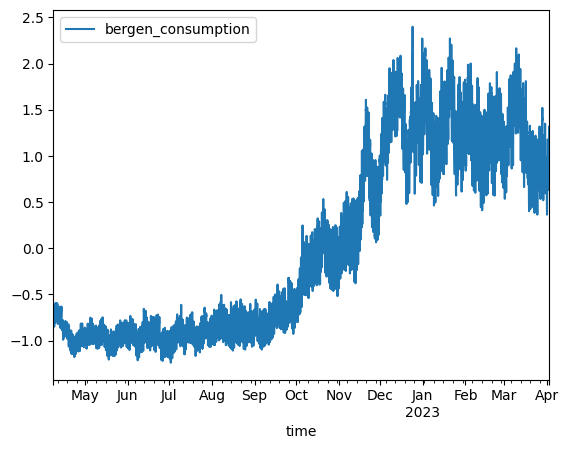

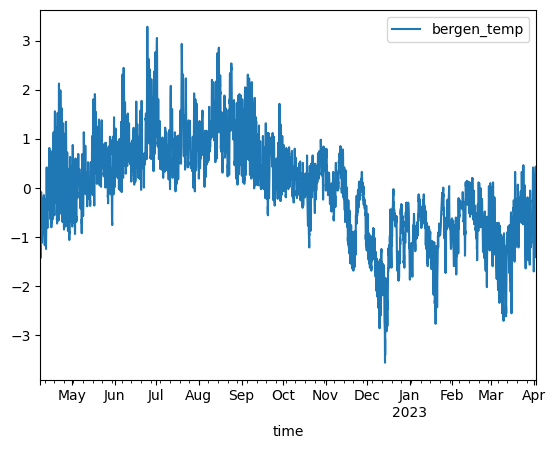

In [12]:
# plot to check if data is standardized
df[['bergen_consumption']].plot()
df[['bergen_temp']].plot()

# Split data

We split the data into training-validation-set and test-set. 
To ensure no leaks we make sure each period does not have overlap.
This however leads to significantly less data than if we would allow for overlap.
Still, we can allow for the test-set to have features from the trainin-validation-set, which makes us able to test on more data or decrease the dedicatedtest-set to train on more data.


To also ensure that the data is varied we split on a cyclic basis to cover seasonality variety in all splits. 
This also leads to even more loss of data... but we believe it is nessecary for the models to see less, but closer data than more data that is further from the same distributions.

It is a pity there is not more data. 1 year is awfully little data and 5 days delay is an awful lot, escpecially when we lose even more y-values due to needing data before. 
Setting up a system to get reliable consumptions hours or just 1 day before forecasts could be looked into. And it could be a possibility to see how that would increase the performance of the models.
However, I suspect that it will be left out.

In [13]:
# create a function to makes splits of the data
# we get time series as output
def split_data(df_, train_val_size, splits):
    # df: df to split
    # train_val_size: size of the training and validation data in float percentage
    # splits: number of splits to make
    train_val = []
    test = []
    split_size = df_.shape[0] // splits
    # loop through the data
    for i in range(splits):
        # get the start and end index of the split
        start = i * split_size
        end = (i + 1) * split_size
        # get the data
        data = df_[start:end]
        # get the train and validation data
        train_val.append(data.index[:int(train_val_size * data.shape[0])])
        # get the test data
        test.append(data.index[int(train_val_size * data.shape[0]):])
    # return the split data
    return np.array(train_val), np.array(test)

In [14]:
# split the data
train_val_times, test_times = split_data(df, 0.8, 3)
train_val_times

array([['2022-04-07T21:00:00.000000000', '2022-04-07T22:00:00.000000000',
        '2022-04-07T23:00:00.000000000', ...,
        '2022-07-12T18:00:00.000000000', '2022-07-12T19:00:00.000000000',
        '2022-07-12T20:00:00.000000000'],
       ['2022-08-05T21:00:00.000000000', '2022-08-05T22:00:00.000000000',
        '2022-08-05T23:00:00.000000000', ...,
        '2022-11-09T18:00:00.000000000', '2022-11-09T19:00:00.000000000',
        '2022-11-09T20:00:00.000000000'],
       ['2022-12-03T21:00:00.000000000', '2022-12-03T22:00:00.000000000',
        '2022-12-03T23:00:00.000000000', ...,
        '2023-03-09T18:00:00.000000000', '2023-03-09T19:00:00.000000000',
        '2023-03-09T20:00:00.000000000']], dtype='datetime64[ns]')

In [15]:
# check the length of each split
train_val_times.shape[1], test_times.shape[1]

(2304, 576)

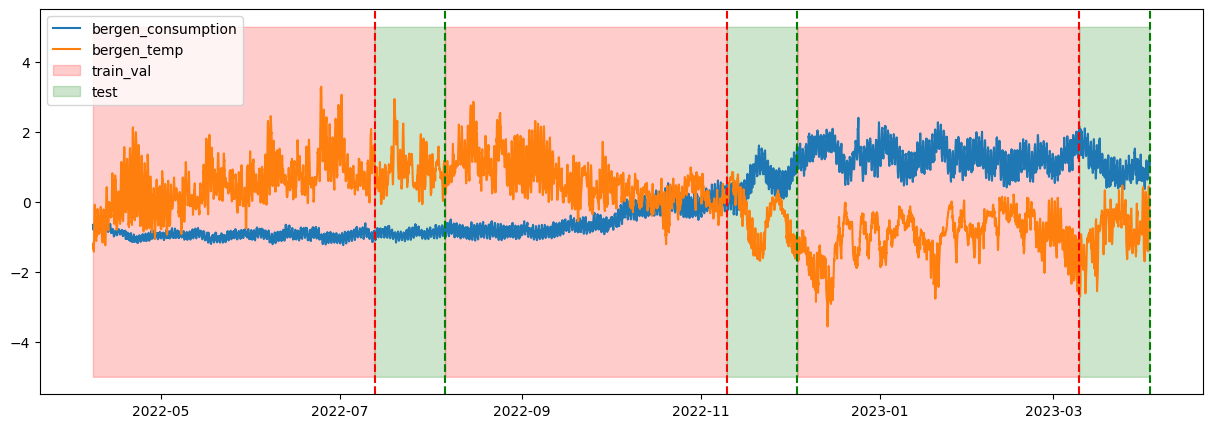

In [16]:
# plot the time splits
def plot_time_splits(city, min_y, max_y, train_val_times, test_times):
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[f'{city}_consumption'], label=f'{city}_consumption')
    plt.plot(df.index, df[f'{city}_temp'], label=f'{city}_temp')

    # Initialize previous period end
    prev_period_end = df.index[0]

    # Alternate between train_val and test times
    for train_period, test_period in zip(train_val_times, test_times):
        # Fill train_val period
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= prev_period_end) & (df.index < train_period[-1]),
                         color='red', alpha=0.2, label='train_val' if prev_period_end == df.index[0] else None)
        # Draw train_val vertical line
        plt.axvline(train_period[-1], color='red', linestyle='--')

        # Fill test period
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= train_period[-1]) & (df.index < test_period[-1]),
                         color='green', alpha=0.2, label='test' if prev_period_end == df.index[0] else None)
        # Draw test vertical line
        plt.axvline(test_period[-1], color='green', linestyle='--')

        # Update previous period end
        prev_period_end = test_period[-1]

    # Handle any remaining train_val period after the last test period
    if len(train_val_times) > len(test_times):
        last_train_period = train_val_times[-1]
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= prev_period_end),
                         color='red', alpha=0.2, label='train_val' if prev_period_end == df.index[0] else None)
        plt.axvline(last_train_period[-1], color='red', linestyle='--')

    # If there are more test periods, handle the last one
    if len(test_times) > len(train_val_times):
        last_test_period = test_times[-1]
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= prev_period_end),
                         color='green', alpha=0.2, label='test' if prev_period_end == df.index[0] else None)
        plt.axvline(last_test_period[-1], color='green', linestyle='--')

    # Add legend
    plt.legend()
    plt.show()
plot_time_splits('bergen', -5, 5, train_val_times, test_times)

# Baseline prediction

In [17]:
def visualize_and_get_metrics(splits, prediction, truth):
    # Setup table to get metrics
    metrics_dict = {'Split': [], 'City': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE': []}

    # Set up the 3x5 grid of subplots
    fig, axs = plt.subplots(splits, 5, figsize=(20, 12))

    for i in range(splits): # For each split
        for j in range(5):  # For each city
            prediction_ = prediction[i, :, j]
            truth_ = truth[i, :, j]
            axis = np.arange(prediction_.shape[0])
            # Calculate mean absolute error
            mae = np.mean(np.abs(prediction_ - truth_))
            # Calculate mean squared error
            mse = np.mean(np.square(prediction_ - truth_))
            # Calculate root mean squared error
            rmse = np.sqrt(mse)
            # Calculate mean absolute percentage error
            mape = np.mean(np.abs((prediction_ - truth_) / truth_)) * 100

            # Store metrics in the dictionary
            metrics_dict['Split'].append(i+1)
            metrics_dict['City'].append(j+1)
            metrics_dict['MAE'].append(mae)
            metrics_dict['MSE'].append(mse)
            metrics_dict['RMSE'].append(rmse)
            metrics_dict['MAPE'].append(mape)
            
            # Plot the prediction_ and truth_
            ax = axs[i, j]
            ax.plot(axis, truth_, label=f'Groundtruth')
            ax.plot(axis, prediction_, label=f'Prediction')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.set_title(f'Split {i+1}, City: {cities[j]}')
            ax.legend()

    # Adjust layout so that plots do not overlap
    plt.tight_layout()

    # Display all the plots
    plt.show()

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame(metrics_dict)

    # Calculate the average of the metrics for each city across splits
    avg_metrics_df = metrics_df.groupby('City').mean().reset_index()

    # Display the metrics table
    print("Metrics per City and Split:")
    display(metrics_df)

    # Display the average metrics per city
    print("\nAverage Metrics per City Across Splits:")
    display(avg_metrics_df)

    # Print the overall means
    print(f'\nOverall Mean Metrics:')
    print(f'Mean MAE: {metrics_df["MAE"].mean()}')
    print(f'Mean MSE: {metrics_df["MSE"].mean()}')
    print(f'Mean RMSE: {metrics_df["RMSE"].mean()}')
    print(f'Mean MAPE: {metrics_df["MAPE"].mean()}')

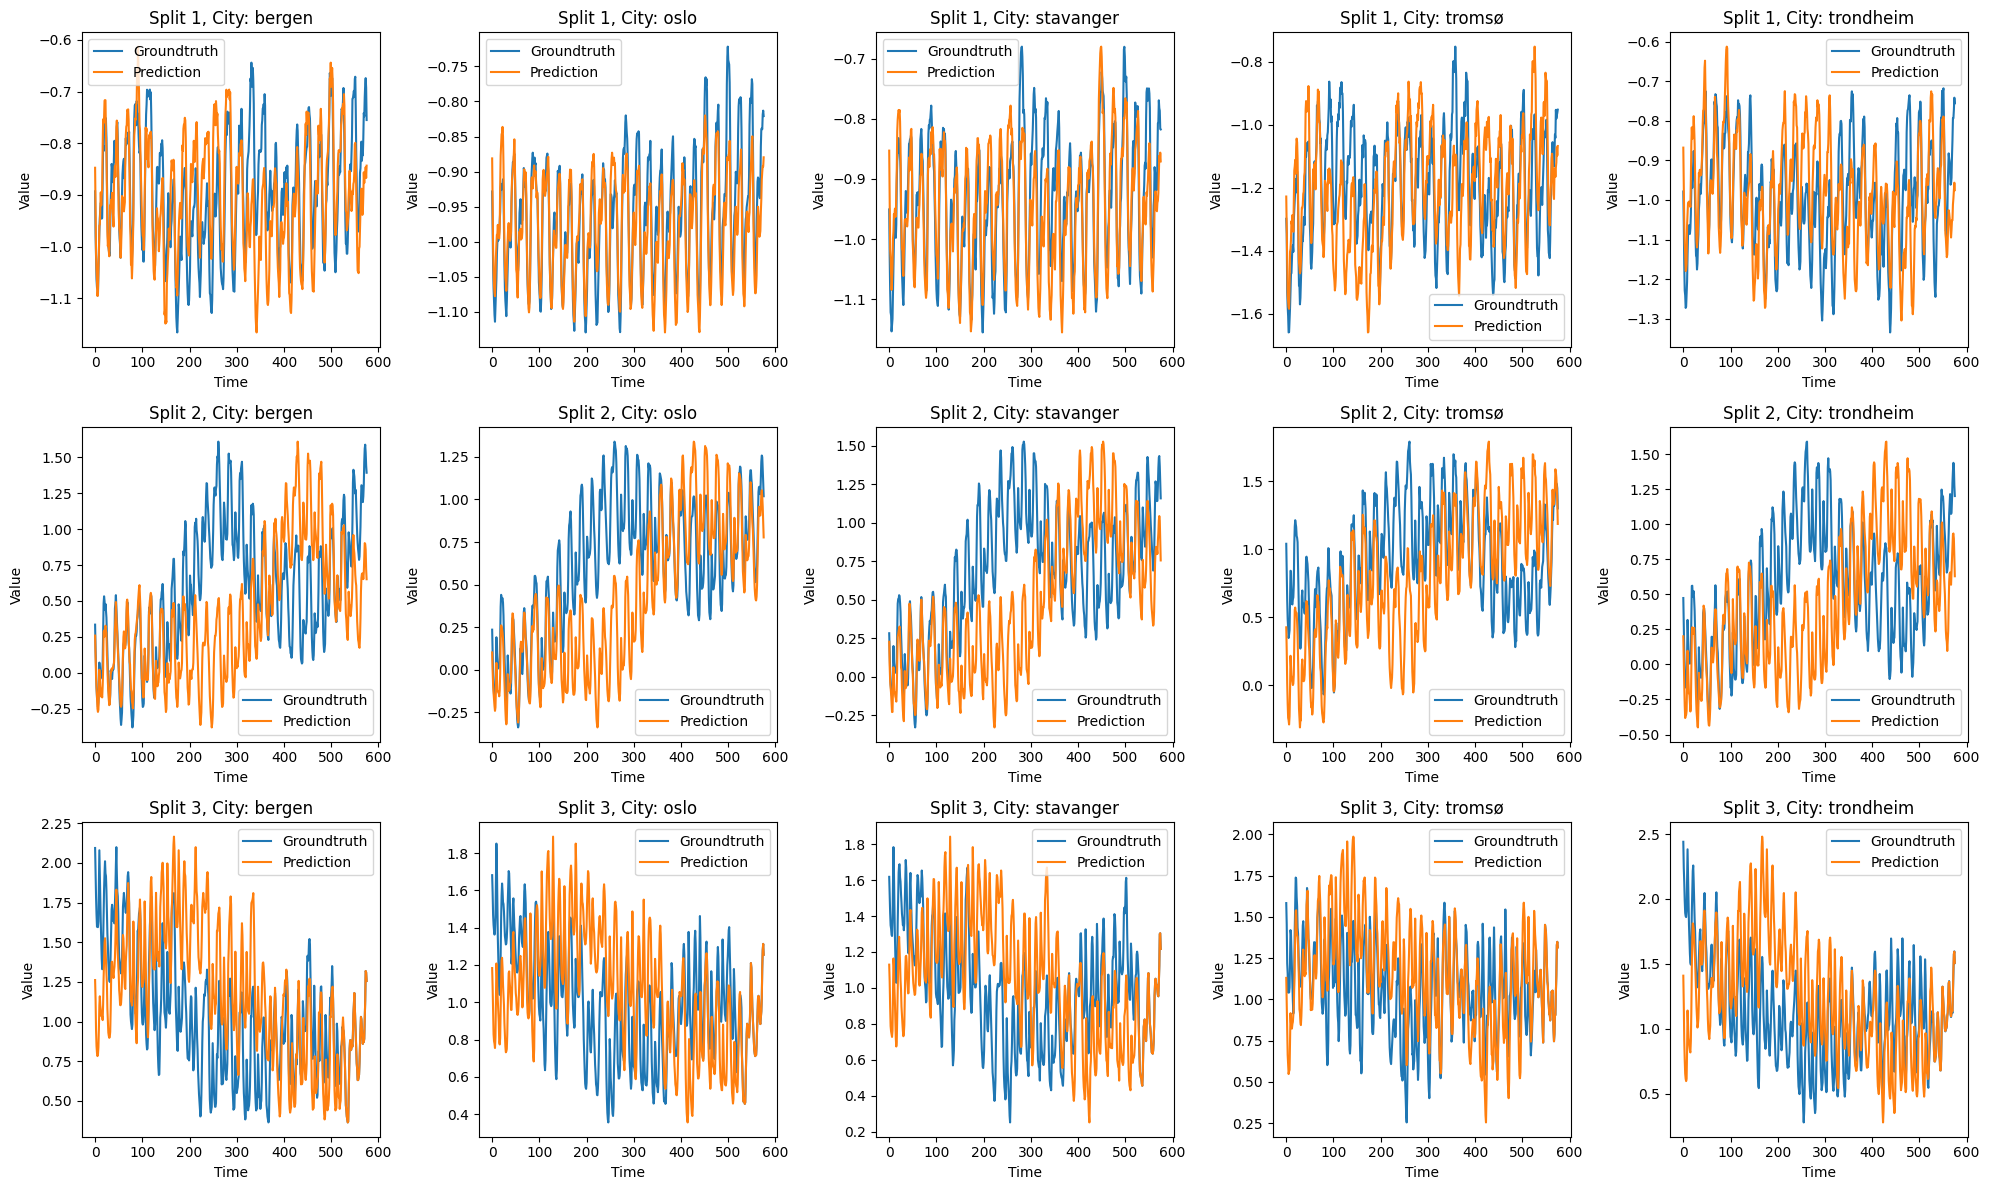

Metrics per City and Split:


,Split,City,MAE,MSE,RMSE,MAPE
0,1,1,0.071915,0.007872,0.088722,8.306219
1,1,2,0.032103,0.001743,0.041749,3.478977
2,1,3,0.046135,0.003405,0.058354,5.171929
3,1,4,0.128130,0.023402,0.152976,11.243498
4,1,5,0.097048,0.013264,0.115170,9.998918
5,2,1,0.406581,0.271465,0.521023,120.018026
6,2,2,0.309582,0.168215,0.410140,174.798689
7,2,3,0.389449,0.240358,0.490263,82.899145
8,2,4,0.373034,0.195103,0.441705,59.226029
9,2,5,0.429086,0.276825,0.526142,203.988150



Average Metrics per City Across Splits:


,City,Split,MAE,MSE,RMSE,MAPE
0,1,2.0,0.270453,0.150952,0.342100,55.666112
1,2,2.0,0.210386,0.098038,0.268083,70.621294
2,3,2.0,0.249409,0.128417,0.308255,41.783562
3,4,2.0,0.240229,0.098840,0.291331,31.336147
4,5,2.0,0.294715,0.164602,0.364221,83.321671



Overall Mean Metrics:
Mean MAE: 0.2530385938524258
Mean MSE: 0.1281698975081186
Mean RMSE: 0.31479802545866103
Mean MAPE: 56.54575720896144


In [18]:
# NB: here we use some of the features in the training data for the test data
# get all dates 1 week before test_dates
train_val_dates = np.concatenate(test_times) - pd.Timedelta(days=7)
truth = df.loc[np.concatenate(test_times), df.columns[:5]].to_numpy()
prediction = df.loc[train_val_dates, df.columns[:5]].to_numpy()
# reshape per split
truth = truth.reshape(3, -1, 5)
prediction = prediction.reshape(3, -1, 5)
# visualize the data
visualize_and_get_metrics(3, prediction, truth)

Potential for more here

Interesting note: When using 3 way split the test data for series 1 SUPER similar, but split 2 and 3 is really different. Maybe something to note for the text.

In [19]:
truth.shape, prediction.shape

((3, 576, 5), (3, 576, 5))

# Model 1: Statistical

In [20]:
# 

# Model 2: XGBoost / Tabular

Here we set up the data in a tabular format with lags.

There are so many choices to make here... I have no idea what is good and what is not. The best would be to try all, but there are WAY too many.
Can list some here:
- Should we have all cities data in the same dataset and predict or should we split per city.
- If we split per city should we train one model or all cities or different per city.
- What features should we include, just the relevant hour of prediction with lags or all hours previously (for a period).

If we just include everything we can test for which columns are good, but I give up on trying that...

I tried to include every feature, but got some matrix shape trouble. Won't bother fixing unless important.

In [21]:
# This tries to use all features of the previous 9 days... There are some issues with shape, won't bother to fix it now.
# JUST LOOK PAST THIS
def tabulize_data_all(matrix):
    # matrix: numpy to tabulize (train, val or test)
    # return: numpy matrices: X, y
    splits = matrix.shape[0]
    X = []
    # get the consumption columns from the 15th day to the end
    y = matrix[:, 14*24:, :5]
    # loop through the splits
    for i in range(splits):
        for j in range(y.shape[1]):
            # get the consumption data from day 1 to 9
            consumption_features = matrix[i, j:j+8*24, :5]
            print(consumption_features.shape)
            temperature_features = matrix[i, j:j+15*24, 5:10]
            print(temperature_features.shape)
            time_features = np.tile(matrix[i, j+15*24, 10:], (5, 1)).T
            print(time_features.shape)
            # append the features
            X.append(np.concatenate([consumption_features, temperature_features, time_features]))

    # return the dataframes
    return np.array(X), np.array(y)

# X, y = tabulize_data_all(train)

In [22]:
# Create a dataset with features:
# - time, week_before and week_before2 (only used to validate that the data is correct)
# - split
# - the same hour consumption the two previous weeks
# - the temperature of the two previous weeks
# - the temperature forecast of the hour
# - the hour of the day
# - the day of the week
# - city
# NB: tabulize is probably the wrong word for this exact operation.
def create_feature_dict(df, times, cities, is_train):
    splits = len(times)
    feature_dict = {
        'time_pred' : [],
        'time_week_before' : [],
        'time_week_before2' : [],
        'split': [], 
        'two_week_consumption': [], 
        'one_week_consumption': [], 
        'two_week_temp': [], 
        'one_week_temp': [], 
        'temp_forecast': [],
        'hour': [],
        'weekday': [],
        'city': [],
        'y': []
    }
    # loop through the splits
    for i in range(splits):
        # first for train_val
        for j in range(times[i, 24*15:].shape[0]):
            for k, city in enumerate(cities):
                # for train
                if is_train:
                    time_pred = times[i, j + 14*24]
                else:
                    # for test
                    time_pred = test_times[i, j]
                week_before = time_pred - pd.Timedelta(days=7)
                week_before2 = time_pred - pd.Timedelta(days=14)
                # add split
                feature_dict['split'].append(i)
                # add hour and day of the week
                feature_dict['hour'].append(df.loc[time_pred, 'hour'])
                feature_dict['weekday'].append(df.loc[time_pred, 'weekday'])
                # get the consumption data of the two previous weeks
                feature_dict['two_week_consumption'].append(df.loc[week_before2, f'{city}_consumption'])
                feature_dict['one_week_consumption'].append(df.loc[week_before, f'{city}_consumption'])
                # get target
                feature_dict['y'].append(df.loc[time_pred, f'{city}_consumption'])
                # get the temperature data of the two previous weeks
                feature_dict['two_week_temp'].append(df.loc[week_before2, f'{city}_temp'])
                feature_dict['one_week_temp'].append(df.loc[week_before, f'{city}_temp'])
                # get the temperature forecast of the hour
                feature_dict['temp_forecast'].append(df.loc[time_pred, f'{city}_temp'])
                # add city
                feature_dict['city'].append(k)
                # add time
                feature_dict['time_pred'].append(time_pred)
                feature_dict['time_week_before'].append(week_before)
                feature_dict['time_week_before2'].append(week_before2)

                # Add consumption and temperature data for all hours between one week and two weeks before
                # for h in range(168):
                #     hour_offset = pd.Timedelta(hours=h)
                #     feature_name_consumption = f'consumption_{h}_hours_before'
                #     feature_name_temp = f'temp_{h}_hours_before'
                #     if feature_name_consumption not in feature_dict:
                #         feature_dict[feature_name_consumption] = []
                #     if feature_name_temp not in feature_dict:
                #         feature_dict[feature_name_temp] = []
                #     feature_dict[feature_name_consumption].append(df.loc[week_before2 + hour_offset, f'{city}_consumption'])
                #     feature_dict[feature_name_temp].append(df.loc[week_before2 + hour_offset, f'{city}_temp'])

    return feature_dict

def tabulize_data_simple(df, train_val_times, test_times):
    # df: df to tabulize (train_val or test)
    # return: dfs:  train_val, (columns for features, last column is y value)
    #               test, (columns for features, last column is y value)

    # get the train_val data
    train_val_dict = create_feature_dict(df, train_val_times, cities, True)
    # get the test data
    test_dict = create_feature_dict(df, test_times, cities, False)

    # return the dataframes
    return pd.DataFrame(train_val_dict), pd.DataFrame(test_dict)
train_val_tabulized_df, test_tabulized_df = tabulize_data_simple(df, train_val_times, test_times)
train_val_tabulized_df.head()

,time_pred,time_week_before,time_week_before2,split,two_week_consumption,one_week_consumption,two_week_temp,one_week_temp,temp_forecast,hour,weekday,city,y
0,2022-04-21 21:00:00,2022-04-14 21:00:00,2022-04-07 21:00:00,0,-0.660391,-0.852927,-1.227807,-0.068669,0.327878,21.0,3.0,0,-0.994897
1,2022-04-21 21:00:00,2022-04-14 21:00:00,2022-04-07 21:00:00,0,-0.595758,-0.775448,-0.728916,-0.512278,0.365675,21.0,3.0,1,-0.943791
2,2022-04-21 21:00:00,2022-04-14 21:00:00,2022-04-07 21:00:00,0,-0.590128,-0.774852,-1.241145,-0.693162,-0.110931,21.0,3.0,2,-0.936759
3,2022-04-21 21:00:00,2022-04-14 21:00:00,2022-04-07 21:00:00,0,-0.168468,-0.520292,-0.930639,-0.252817,0.048437,21.0,3.0,3,-0.602854
4,2022-04-21 21:00:00,2022-04-14 21:00:00,2022-04-07 21:00:00,0,-0.271248,-0.645900,-1.183463,-0.632015,0.011341,21.0,3.0,4,-0.733354


In [23]:
df.head()

,bergen_consumption,oslo_consumption,stavanger_consumption,tromsø_consumption,trondheim_consumption,bergen_temp,oslo_temp,stavanger_temp,tromsø_temp,trondheim_temp,hour,weekday
time,,,,,,,,,,,,
2022-04-07 21:00:00,-0.660391,-0.595758,-0.590128,-0.168468,-0.271248,-1.227807,-0.728916,-1.241145,-0.930639,-1.183463,21.0,3.0
2022-04-07 22:00:00,-0.714890,-0.654558,-0.655851,-0.286978,-0.386136,-1.182052,-0.797328,-1.326767,-0.980848,-1.249112,22.0,3.0
2022-04-07 23:00:00,-0.750819,-0.688184,-0.701877,-0.360968,-0.466829,-1.258311,-0.808730,-1.275394,-1.081266,-1.314761,23.0,3.0
2022-04-08 00:00:00,-0.772093,-0.704646,-0.720685,-0.357688,-0.505958,-1.349822,-0.820132,-1.275394,-1.156579,-1.367279,0.0,4.0
2022-04-08 01:00:00,-0.801390,-0.712036,-0.738556,-0.358079,-0.513762,-1.288814,-0.797328,-1.292518,-0.930639,-1.354150,1.0,4.0


In [24]:
df.to_numpy().shape

(8641, 12)

In [25]:
train_val_times

array([['2022-04-07T21:00:00.000000000', '2022-04-07T22:00:00.000000000',
        '2022-04-07T23:00:00.000000000', ...,
        '2022-07-12T18:00:00.000000000', '2022-07-12T19:00:00.000000000',
        '2022-07-12T20:00:00.000000000'],
       ['2022-08-05T21:00:00.000000000', '2022-08-05T22:00:00.000000000',
        '2022-08-05T23:00:00.000000000', ...,
        '2022-11-09T18:00:00.000000000', '2022-11-09T19:00:00.000000000',
        '2022-11-09T20:00:00.000000000'],
       ['2022-12-03T21:00:00.000000000', '2022-12-03T22:00:00.000000000',
        '2022-12-03T23:00:00.000000000', ...,
        '2023-03-09T18:00:00.000000000', '2023-03-09T19:00:00.000000000',
        '2023-03-09T20:00:00.000000000']], dtype='datetime64[ns]')

In [26]:
train_val_times.shape

(3, 2304)

In [27]:
df.index.get_loc(train_val_times[1, 2])

2882

In [28]:
import numpy as np
import pandas as pd

# - time, week_before and week_before2 (only used to validate that the data is correct)
# - split
# - the same hour consumption the two previous weeks
# - the temperature of the two previous weeks
# - the temperature forecast of the hour
# - the hour of the day
# - the day of the week
# - city
# - city_number
# - the target value (consumption of the hour)

def create_feature_matrix(df, times, cities, is_train):
    time_index = df.index
    np_df = df.to_numpy()
    num_cities = len(cities)
    num_times = times.shape[1]
    num_splits = times.shape[0]
    offset = 24*14 if is_train else 0
    split_length = num_times - offset

    num_manual_features = 9
    
    # Pre-calculate indexes for consumption and temperature features
    consumption_idxs = np.arange(-2*24*7, -1*24*5) # consumption from 2 weeks to 5 days before
    temp_idxs = np.arange(-2*24*7, 0) # temperature from 2 weeks to 1 hour before
    
    # Pre-allocate feature arrays with the correct size
    num_features = num_manual_features + consumption_idxs.shape[0] + temp_idxs.shape[0] # basic features + consumption and temp for each hour
    features = np.zeros(((split_length) * num_splits * num_cities, num_features), dtype=object)
    # Fill in the feature values
    for split in range(num_splits):
        for i in range(offset, num_times):
            for city_idx, city in enumerate(cities):
                time_pred = times[split, i]
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 0] = times[split, i]
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 1] = times[split, i] - pd.Timedelta(days=7) # alt1
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 2] = time_index[time_index.get_loc(times[split, i]) - 24*14] # alt2
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 3] = split
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 4] = df.loc[time_pred, 'hour']
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 5] = df.loc[time_pred, 'weekday']
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 6] = city
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 7] = city_idx
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 8] = df.loc[time_pred, f'{city}_consumption']
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), num_manual_features:(num_manual_features+len(consumption_idxs))] = df.loc[time_pred + pd.to_timedelta(consumption_idxs, unit='H'), f'{city}_consumption'].values
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), (num_manual_features+len(consumption_idxs)):] = df.loc[time_pred + pd.to_timedelta(temp_idxs, unit='H'), f'{city}_temp'].values
    
    # Reshape the features to a 2D array where each row is a single sample
    features = features.reshape(-1, num_features)
    
    # Create a feature dictionary from the NumPy array
    feature_dict = {
        'time_pred': features[:, 0],
        'time_week_before': features[:, 1],
        'time_week_before2': features[:, 2],
        'split': features[:, 3],
        'hour': features[:, 4],
        'weekday': features[:, 5],
        'city': features[:, 6],
        'city_number' : features[:, 7],
        'y': features[:, 8]
    }
    
    # Add consumption and temperature features
    for h, idx in enumerate(consumption_idxs, start=1):
        feature_dict[f'consumption_{-idx}_hours_before'] = features[:, num_manual_features+h]
    for h, idx in enumerate(temp_idxs, start=1):
        feature_dict[f'temp_{-idx}_hours_before'] = features[:, num_manual_features+h]
    
    return pd.DataFrame(feature_dict)

def tabulize_data(df, train_val_times, test_times, cities):
    train_val_df = create_feature_matrix(df, train_val_times, cities, True)
    test_df = create_feature_matrix(df, test_times, cities, False)
    return train_val_df, test_df

# Example usage
train_val_tabulized_df, test_tabulized_df = tabulize_data(df, train_val_times, test_times, cities)
train_val_tabulized_df

,time_pred,time_week_before,time_week_before2,split,hour,weekday,city,city_number,y,consumption_336_hours_before,...,temp_10_hours_before,temp_9_hours_before,temp_8_hours_before,temp_7_hours_before,temp_6_hours_before,temp_5_hours_before,temp_4_hours_before,temp_3_hours_before,temp_2_hours_before,temp_1_hours_before
0,2022-04-21 21:00:00,2022-04-14 21:00:00,2022-04-07 21:00:00,0,21.0,3.0,bergen,0,-0.994897,-0.71489,...,0.388885,0.404137,0.419389,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572
1,2022-04-21 22:00:00,2022-04-14 22:00:00,2022-04-07 22:00:00,0,22.0,3.0,bergen,0,-1.061516,-0.750819,...,0.404137,0.419389,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476
2,2022-04-21 23:00:00,2022-04-14 23:00:00,2022-04-07 23:00:00,0,23.0,3.0,bergen,0,-1.105746,-0.772093,...,0.419389,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476,-0.632986
3,2022-04-22 00:00:00,2022-04-15 00:00:00,2022-04-08 00:00:00,0,0.0,4.0,bergen,0,-1.145188,-0.80139,...,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476,-0.632986,-0.739749
4,2022-04-22 01:00:00,2022-04-15 01:00:00,2022-04-08 01:00:00,0,1.0,4.0,bergen,0,-1.131515,-0.777862,...,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476,-0.632986,-0.739749,-0.739749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29515,2023-03-09 16:00:00,2023-03-02 16:00:00,2023-02-23 16:00:00,2,16.0,3.0,trondheim,4,1.858542,1.581319,...,-0.159345,-0.172475,-0.133086,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994
29516,2023-03-09 17:00:00,2023-03-02 17:00:00,2023-02-23 17:00:00,2,17.0,3.0,trondheim,4,2.000461,1.563706,...,-0.172475,-0.133086,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994,-0.277513
29517,2023-03-09 18:00:00,2023-03-02 18:00:00,2023-02-23 18:00:00,2,18.0,3.0,trondheim,4,2.230106,1.614958,...,-0.133086,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994,-0.277513,-0.290642
29518,2023-03-09 19:00:00,2023-03-02 19:00:00,2023-02-23 19:00:00,2,19.0,3.0,trondheim,4,2.401012,1.584479,...,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994,-0.277513,-0.290642,-0.303772


## XGBoost all cities

In [29]:
# get X_train, y_train, X_test, y_test
def get_X_y(df):
    # df: df to get X and y from
    # return: X, y
    X = df.drop(columns=['time_pred', 'time_week_before', 'time_week_before2', 'y', 'city'])
    y = df['y']
    return X, y

X_train, y_train = get_X_y(train_val_tabulized_df)
X_test, y_test = get_X_y(test_tabulized_df)

In [30]:
X_train

,split,hour,weekday,city_number,consumption_336_hours_before,consumption_335_hours_before,consumption_334_hours_before,consumption_333_hours_before,consumption_332_hours_before,consumption_331_hours_before,...,temp_10_hours_before,temp_9_hours_before,temp_8_hours_before,temp_7_hours_before,temp_6_hours_before,temp_5_hours_before,temp_4_hours_before,temp_3_hours_before,temp_2_hours_before,temp_1_hours_before
0,0,21.0,3.0,0,-0.71489,-0.750819,-0.772093,-0.80139,-0.777862,-0.788657,...,0.388885,0.404137,0.419389,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572
1,0,22.0,3.0,0,-0.750819,-0.772093,-0.80139,-0.777862,-0.788657,-0.737196,...,0.404137,0.419389,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476
2,0,23.0,3.0,0,-0.772093,-0.80139,-0.777862,-0.788657,-0.737196,-0.645011,...,0.419389,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476,-0.632986
3,0,0.0,4.0,0,-0.80139,-0.777862,-0.788657,-0.737196,-0.645011,-0.658767,...,0.251619,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476,-0.632986,-0.739749
4,0,1.0,4.0,0,-0.777862,-0.788657,-0.737196,-0.645011,-0.658767,-0.701592,...,0.17536,0.053345,-0.053418,-0.190684,-0.282195,-0.49572,-0.541476,-0.632986,-0.739749,-0.739749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29515,2,16.0,3.0,4,1.581319,1.563706,1.614958,1.584479,1.523881,1.3543,...,-0.159345,-0.172475,-0.133086,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994
29516,2,17.0,3.0,4,1.563706,1.614958,1.584479,1.523881,1.3543,1.16735,...,-0.172475,-0.133086,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994,-0.277513
29517,2,18.0,3.0,4,1.614958,1.584479,1.523881,1.3543,1.16735,0.948273,...,-0.133086,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994,-0.277513,-0.290642
29518,2,19.0,3.0,4,1.584479,1.523881,1.3543,1.16735,0.948273,0.848235,...,-0.067437,-0.146215,-0.146215,-0.119956,-0.080567,-0.146215,-0.224994,-0.277513,-0.290642,-0.303772


<Axes: >

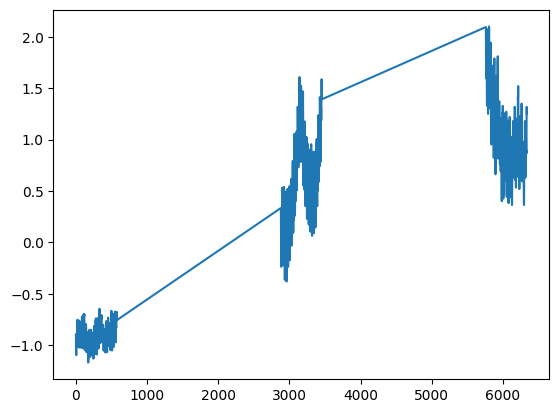

In [106]:
# plot consumption and temperature of bergen
y_test[X_test['city_number'] == 0].plot()

In [33]:
import xgboost as xgb

In [110]:
# get dfs as numpy
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

print(X_train_np.shape)
print(y_train_np.shape)

# Create DMatrix for the current city
dtrain_city = xgb.DMatrix(X_train_np, label=y_train_np)

# Define XGBoost parameters for the current city's model
params = {
    'max_depth': 4,
    'eta': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'  # or 'mae' or another suitable metric for your task
}

# Train the model for the current city
xg_model = xgb.train(params, dtrain_city, num_boost_round=100)

(29520, 556)
(29520,)


In [111]:
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()
print(X_test_np.shape, y_test_np.shape)

(8640, 556) (8640,)


In [112]:
# Create DMatrix for validation set of the current city
dval_city = xgb.DMatrix(X_test_np)

# Predict using the trained model for the current city
xg_predictions = xg_model.predict(dval_city)

# xg_predictions = xg_predictions.reshape(3, -1, 5)

# Reshape the predictions to match the shape of y_val
xg_truths = y_test_np

xg_truths.shape, xg_predictions.shape

((8640,), (8640,))

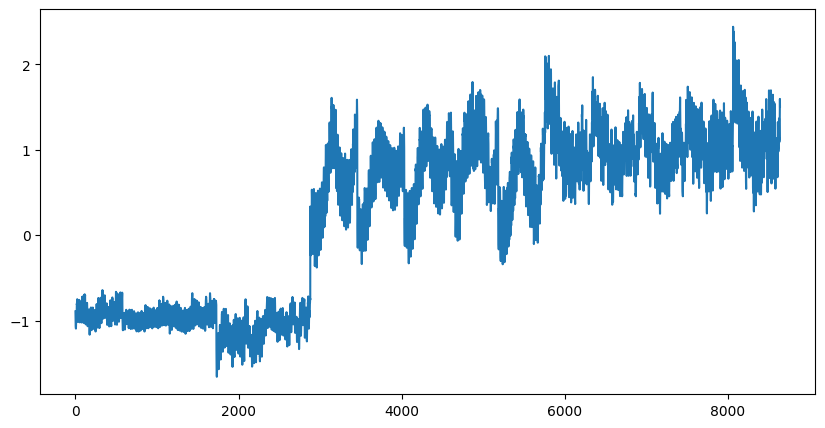

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(xg_truths)

In [114]:
# reshape the predictions
xg_predictions = np.transpose(xg_predictions.reshape(3, 5, -1), axes=(0, 2, 1))
# reshape the truths
xg_truths = np.transpose(xg_truths.reshape(3, 5, -1), axes=(0, 2, 1))

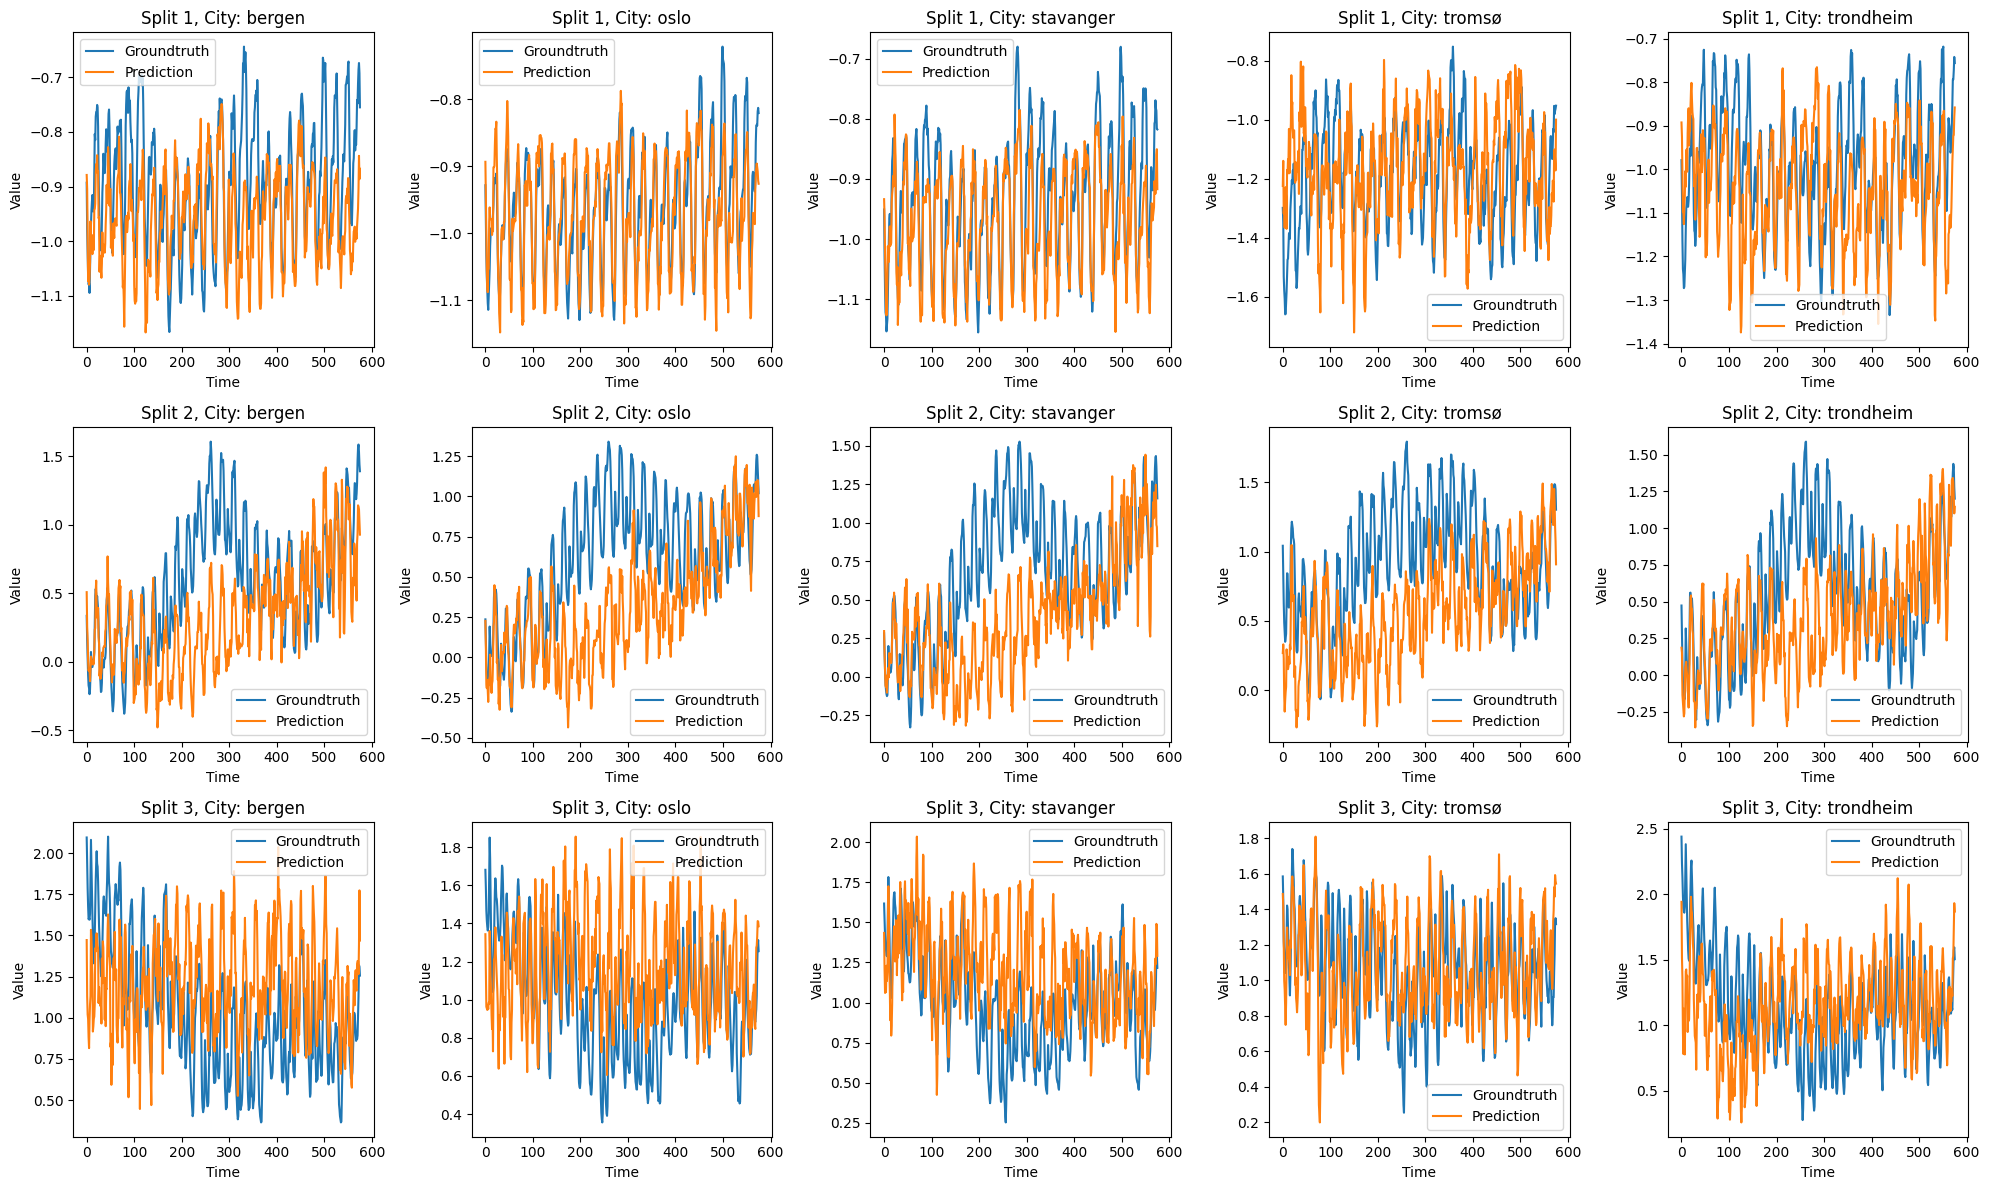

Metrics per City and Split:


,Split,City,MAE,MSE,RMSE,MAPE
0,1,1,0.087202,0.011931,0.109228,10.504775
1,1,2,0.035211,0.002119,0.046035,3.785057
2,1,3,0.052023,0.004670,0.068338,5.960701
3,1,4,0.145438,0.031304,0.176929,12.415594
4,1,5,0.104893,0.015515,0.124557,11.082419
5,2,1,0.356944,0.218745,0.467702,154.238022
6,2,2,0.357598,0.208500,0.456618,150.244319
7,2,3,0.374221,0.236379,0.486188,81.396451
8,2,4,0.438856,0.268611,0.518277,58.584423
9,2,5,0.319759,0.172246,0.415026,162.442870



Average Metrics per City Across Splits:


,City,Split,MAE,MSE,RMSE,MAPE
0,1,2.0,0.269899,0.135826,0.332470,69.290401
1,2,2.0,0.228783,0.110887,0.283999,63.012851
2,3,2.0,0.236893,0.119628,0.299266,41.014244
3,4,2.0,0.259924,0.118843,0.311048,30.666289
4,5,2.0,0.252731,0.115383,0.312521,69.398877



Overall Mean Metrics:
Mean MAE: 0.24964617047996882
Mean MSE: 0.12011358674881854
Mean RMSE: 0.3078608557325276
Mean MAPE: 54.67653236389988


In [115]:
# Visualize and get metrics
visualize_and_get_metrics(splits=3, prediction=xg_predictions, truth=xg_truths)

# Model 3: RNN-types

For RNNs (LSTM), and our modified Transformer model we need Sequence data.

We input sequences of 9 days at a time and inject the projected forecast.

In [ ]:
def sequencize_data(matrix, sequence_length):
    # matrix: numpy to sequencize (train, val or test)
    # sequence_length: length of the sequence
    # return: numpy matrices: consumption, other_features, y
    # consumption: (splits, num_sequences, sequence_length, 1, cities)
    # other_features: (splits, num_sequences, sequence_length*2, temp_time_weekday, cities)
    # y: (splits, num_sequences, sequence_length, 1, cities)
    splits = matrix.shape[0]
    split_length = matrix.shape[1]
    num_sequences = split_length - sequence_length * 2
    consumption = np.zeros((3, num_sequences, sequence_length, 1, 5))
    other_features = np.zeros((3, num_sequences, sequence_length*2, 3, 5))
    y = np.zeros((3, num_sequences, sequence_length, 1, 5))
    # loop through the splits
    for i in range(splits):
        for j in range(num_sequences):
            # get the consumption data from day 1 to sequence_length
            consumption_features = matrix[i, j:j+sequence_length, :5]
            consumption_targets = matrix[i, j+sequence_length:j+sequence_length*2, :5]
            # get the temperature data from day 1 to sequence_length*2
            temperature_features = np.expand_dims(matrix[i, j:j+sequence_length*2, 5:10], axis=1)
            # get the time and weekday data from day 1 to sequence_length*2
            time_features = np.reshape(np.tile(matrix[i, j:j+sequence_length*2, 10:], (1, 5)), (sequence_length*2, 2, 5))

            other_features_ = np.concatenate([temperature_features, time_features], axis=1)
            # concatenate the features
            other_features[i, j, :, :, :] = other_features_
            # append the features
            consumption[i, j, :, 0, :] = consumption_features
            y[i, j, :, 0, :] = consumption_targets

    # return the dataframes
    return np.array(consumption), np.array(other_features), np.array(y)

In [ ]:
consumption, other_features, y = sequencize_data(train, 216)
consumption.shape, other_features.shape, y.shape

((3, 1296, 216, 1, 5), (3, 1296, 432, 3, 5), (3, 1296, 216, 1, 5))

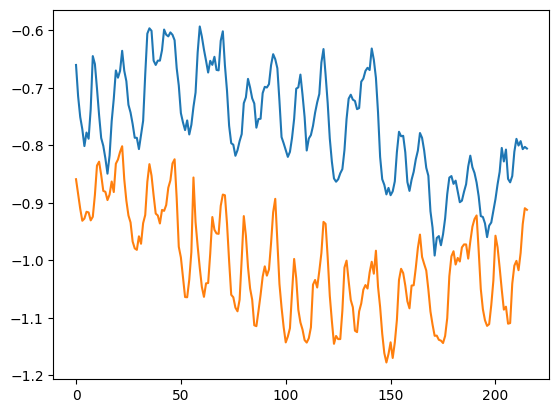

In [ ]:
# plot consumption vs y to check if it is correct
plt.plot(consumption[0, 0, :, 0, 0])
plt.plot(y[0, 0, :, 0, 0])

Days seems to line up

Function to count parameters

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

## LSTM-1

In [ ]:
import torch as T
import torch.nn as nn
import torch.optim as optim

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1, output_size=1):
        super(TimeSeriesLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, verbose=False):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # LSTM
        out, _ = self.lstm(x)  # out shape: (batch_size, sequence_length, hidden_size)

        if verbose:
            print('1:', out.shape)
        
        # Take the relevant steps from the LSTM output
        out = out[:, :, :]

        if verbose:
            print('2:', out.shape)
        
        # Linear layer to get the output
        out = self.linear(out)  # out shape: (batch_size, 4, output_size)

        out = out[:, :, -1:]
        out = out.view(-1, 1, 216)

        if verbose:
            print('3:',out.shape)
        
        return out
    
model = TimeSeriesLSTM()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 17985
Trainable parameters: 17985


In [ ]:
model = TimeSeriesLSTM().to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(3100, 216, 4, device='cuda')
out = model(input, verbose=True)

1: torch.Size([3100, 216, 64])
2: torch.Size([3100, 216, 64])
3: torch.Size([3100, 1, 216])


In [ ]:
import torch
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get data as tensors
X_consumption_train, X_other_train, y_train = sequencize_data(train, 216)
X_consumption_val, X_other_val, y_val = sequencize_data(val, 216)
X_train = np.concatenate((X_consumption_train, X_other_train[:,:,:216,:,:]), axis=3)
X_val = np.concatenate((X_consumption_val, X_other_val[:,:,:216,:,:]), axis=3)

train_X = torch.tensor(X_train, dtype=torch.float32).to(device)
train_y = torch.tensor(y_train, dtype=torch.float32).to(device)
val_X = torch.tensor(X_val, dtype=torch.float32).to(device)
val_y = torch.tensor(y_val, dtype=torch.float32).to(device)

# merge first dimension
train_X = train_X.reshape((-1, 216, 4, 5))
train_y = train_y.reshape((-1, 216, 1, 5))

In [ ]:
model = TimeSeriesLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
models = []
for i in range(5):
    # Instantiate dataset
    train_dataset = TimeSeriesDataset(train_X[:,:,:,i], train_y[:,:,:,i])
    # Instantiate data loader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    print(f"Training model for city {i+1}")
    model = TimeSeriesLSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_model(model, train_loader, criterion, optimizer, epochs=10)
    models.append(model)

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_5568\2765471666.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_5568\2765471666.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)
c:\Users\Ferdinand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 216, 1])) that is different to the input size (torch.Size([64, 1, 216])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, red

Training model for city 1


c:\Users\Ferdinand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([48, 216, 1])) that is different to the input size (torch.Size([48, 1, 216])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/10], Loss: 0.9600
Epoch [4/10], Loss: 0.0973
Epoch [6/10], Loss: 0.1172
Epoch [8/10], Loss: 0.1035
Epoch [10/10], Loss: 0.0935
Training model for city 2
Epoch [2/10], Loss: 0.8990
Epoch [4/10], Loss: 0.1154
Epoch [6/10], Loss: 0.0831
Epoch [8/10], Loss: 0.0949
Epoch [10/10], Loss: 0.1002
Training model for city 3
Epoch [2/10], Loss: 0.8970
Epoch [4/10], Loss: 0.0893
Epoch [6/10], Loss: 0.1052
Epoch [8/10], Loss: 0.0929
Epoch [10/10], Loss: 0.0764
Training model for city 4
Epoch [2/10], Loss: 0.5740
Epoch [4/10], Loss: 0.1668
Epoch [6/10], Loss: 0.1242
Epoch [8/10], Loss: 0.1173
Epoch [10/10], Loss: 0.1310
Training model for city 5
Epoch [2/10], Loss: 0.4961
Epoch [4/10], Loss: 0.1112
Epoch [6/10], Loss: 0.1279
Epoch [8/10], Loss: 0.1427
Epoch [10/10], Loss: 0.1300


In [ ]:
val_X.shape, val_y.shape

(torch.Size([3, 144, 216, 4, 5]), torch.Size([3, 144, 216, 1, 5]))

In [ ]:
predictions = np.zeros((3, 144, 216, 5))

for i in range(3):  # For each split
    for j in range(5):  # For each city
        # Extract the validation features
        city_val_features = val_X[i, :, :, :, j] 

        model.eval()
        outputs_list = []
        with torch.no_grad():
            outputs = model(city_val_features)
        xg_predictions = outputs.squeeze().cpu().numpy()

        # Store the predictions
        predictions[i, :, :, j] = xg_predictions

In [ ]:
truths = val_y.cpu().numpy()
predictions.shape, truths.shape

((3, 144, 216, 5), (3, 144, 216, 1, 5))

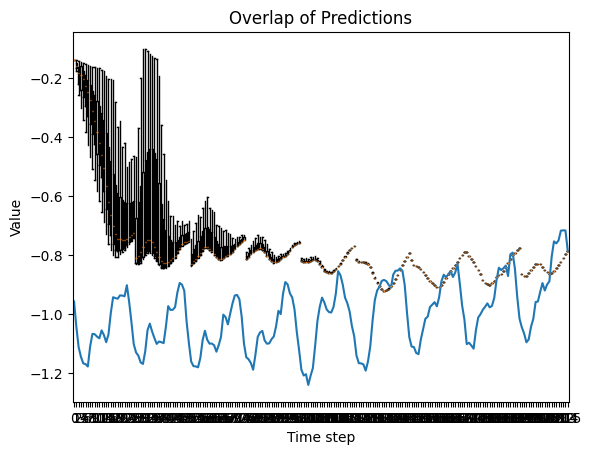

In [ ]:
import matplotlib.pyplot as plt

_predictions = predictions[0, :, :, 0]
_truths = truths[0, 0, :, 0, 0]

# Prepare data for boxplot
data_to_plot = []
for i in range(216):  # For each predicted time step
    # Collect all predictions that include this time step, ensuring we don't go out of bounds
    data_at_timestep = [_predictions[j, i-j] for j in range(min(i+1, 144)) if i-j < 216]
    data_to_plot.append(data_at_timestep)

# Create a boxplot
plt.boxplot(data_to_plot, positions=range(216), showfliers=False)
plt.plot(_truths, label='Truth')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Overlap of Predictions')
plt.show()

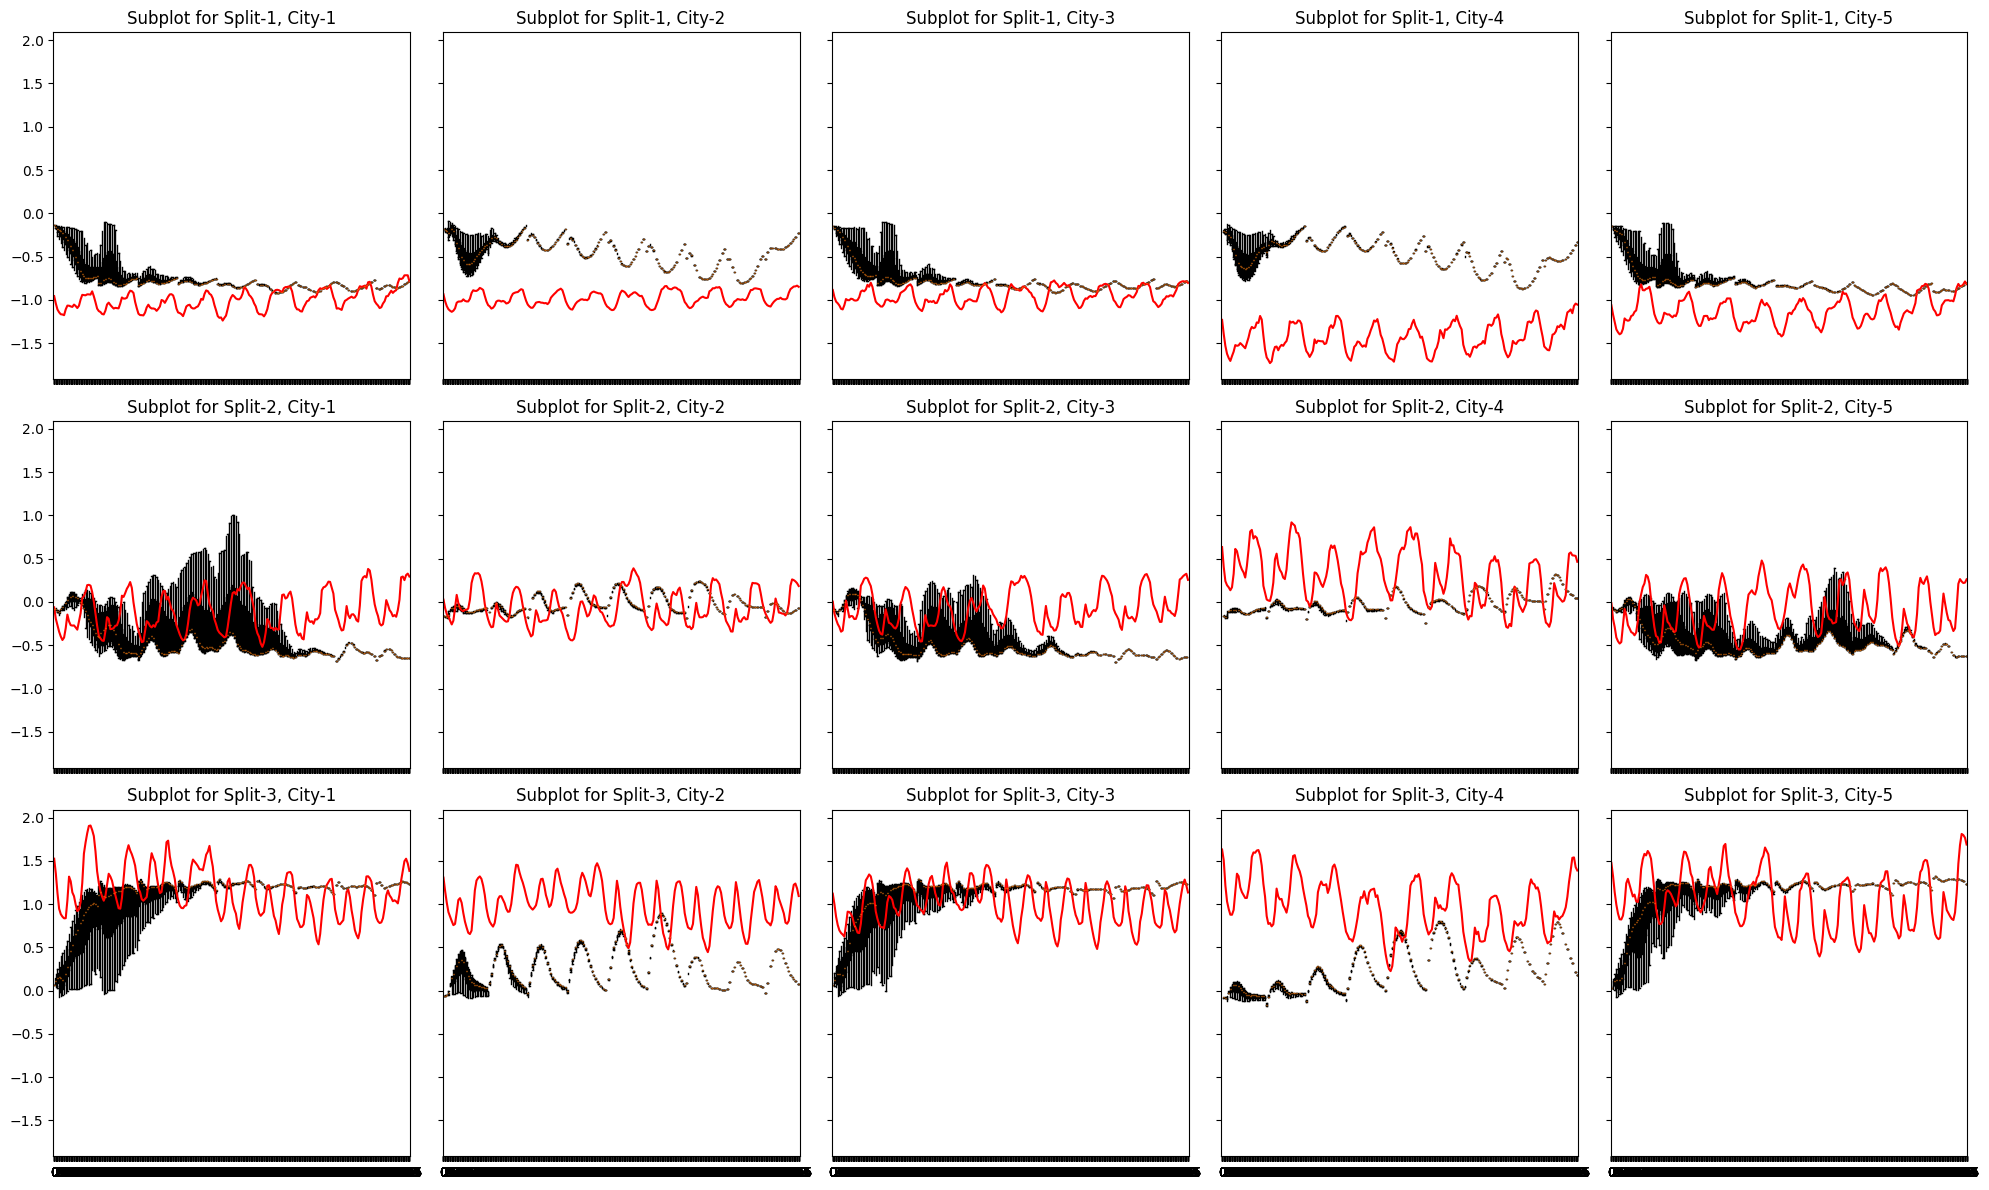

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharex=True, sharey=True)

# Iterate over the subplots and fill each with corresponding data
for i in range(3):  # Three rows
    for j in range(5):  # Five columns
        _predictions = predictions[i, :, :, j]
        _truths = truths[i, 0, :, 0, j]

        data_to_plot = []
        # Prepare data for boxplot for each predicted time step
        for t in range(216):
            # Collect all predictions that include this time step, ensuring we don't go out of bounds
            data_at_timestep = [_predictions[k, t-k] for k in range(min(t+1, 144)) if t-k < 216]
            data_to_plot.append(data_at_timestep)

        # Plotting on the ith row and jth column subplot
        ax = axes[i, j]
        ax.boxplot(data_to_plot, positions=range(216), showfliers=False)
        ax.plot(_truths, label='Truth', color='red')  # Overlay the truth values
        ax.set_title(f'Subplot for Split-{i+1}, City-{j+1}')

# Adjust layout
plt.tight_layout()
plt.show()

## LSTM try 2

In [ ]:
import torch as T
import torch.nn as nn
import torch.optim as optim

class TimeSeriesLSTM2(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1, output_size=1):
        super(TimeSeriesLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, verbose=False):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # LSTM
        out, _ = self.lstm(x)  # out shape: (batch_size, sequence_length, hidden_size)

        if verbose:
            print('1:', out.shape)
        
        # Take the relevant steps from the LSTM output
        out = out[:, :, :]

        if verbose:
            print('2:', out.shape)
        
        # Linear layer to get the output
        out = self.linear(out)  # out shape: (batch_size, 4, output_size)

        out = out[:, :, -1:]
        out = out.view(-1, 1, 216)

        if verbose:
            print('3:',out.shape)
        
        return out
    
model = TimeSeriesLSTM()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 31960
Trainable parameters: 31960


In [ ]:
model = TimeSeriesLSTM().to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(3100, 216, 4, device='cuda')
out = model(input, verbose=True)

1: torch.Size([3100, 216, 64])
2: torch.Size([3100, 216, 64])
3: torch.Size([3100, 1, 216])


## Dual-Input LSTM

In [ ]:
class DualInputLSTM(nn.Module):
    def __init__(self, consumption_size, temperature_size, hidden_layer_size, output_size):
        super(DualInputLSTM, self).__init__()
        
        # LSTM for consumption data
        self.lstm_consumption = nn.LSTM(consumption_size, hidden_layer_size, batch_first=True)
        
        # LSTM for temperature data
        self.lstm_temperature = nn.LSTM(temperature_size, hidden_layer_size, batch_first=True)
        
        # Linear layer to combine the outputs of the two LSTMs
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)
    
    def forward(self, consumption_seq, temperature_seq):
        # Process each sequence through its respective LSTM
        lstm_out_consumption, _ = self.lstm_consumption(consumption_seq)
        lstm_out_temperature, _ = self.lstm_temperature(temperature_seq)
        
        # Concatenate the final outputs of each LSTM
        combined = torch.cat((lstm_out_consumption[:, -1, :], lstm_out_temperature[:, -1, :]), 1)
        
        # Make predictions based on the combined output
        predictions = self.linear(combined)
        return predictions

# Assuming each timestep has a single feature for consumption/temperature
consumption_size = 1
temperature_size = 1
hidden_layer_size = 50
output_size = 9

model = DualInputLSTM(consumption_size, temperature_size, hidden_layer_size, output_size)

# LSTM Take 2

In [ ]:
class VectorOutputLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, n_future, device):
        super(VectorOutputLSTM, self).__init__()

        self.device = device
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim * n_future)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device).requires_grad_()
        
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.linear(out[:, -1, :])
        
        # Reshape to get predictions for the future time steps
        return out.view(x.size(0), -1)
    
# model = VectorOutputLSTM(12, 64, 1, 12, 5, 'cuda')
# total_params, trainable_params = count_parameters(model)
# print(f"Total parameters: {total_params}")
# print(f"Trainable parameters: {trainable_params}")

In [ ]:
model = VectorOutputLSTM(12, 64, 1, 5, WINDOW_SIZE_Y+GAP_PREDICTION, 'cuda').to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12, device='cuda')
out = model(input)
print(out.shape)

torch.Size([25, 185])


In [ ]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VectorOutputLSTM(12, 64, 1, 5, WINDOW_SIZE_Y+GAP_PREDICTION, 'cuda').to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_X, train_y, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]
        # print(outputs.shape)

        train_y = train_y[:,:,:5]
        # print(train_y.shape)

        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs.view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model(model, train_X, train_y, criterion, optimizer, epochs=1000)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/1000], Loss: 0.8473
Epoch [20/1000], Loss: 0.6195
Epoch [30/1000], Loss: 0.3645
Epoch [40/1000], Loss: 0.1677
Epoch [50/1000], Loss: 0.0793
Epoch [60/1000], Loss: 0.0529
Epoch [70/1000], Loss: 0.0426
Epoch [80/1000], Loss: 0.0373
Epoch [90/1000], Loss: 0.0337
Epoch [100/1000], Loss: 0.0313
Epoch [110/1000], Loss: 0.0294
Epoch [120/1000], Loss: 0.0282
Epoch [130/1000], Loss: 0.0270
Epoch [140/1000], Loss: 0.0261
Epoch [150/1000], Loss: 0.0253
Epoch [160/1000], Loss: 0.0246
Epoch [170/1000], Loss: 0.0241
Epoch [180/1000], Loss: 0.0235
Epoch [190/1000], Loss: 0.0231
Epoch [200/1000], Loss: 0.0225
Epoch [210/1000], Loss: 0.0225
Epoch [220/1000], Loss: 0.0221
Epoch [230/1000], Loss: 0.0213
Epoch [240/1000], Loss: 0.0210
Epoch [250/1000], Loss: 0.0206
Epoch [260/1000], Loss: 0.0202
Epoch [270/1000], Loss: 0.0198
Epoch [280/1000], Loss: 0.0195
Epoch [290/1000], Loss: 0.0199
Epoch [300/1000], Loss: 0.0191
Epoch [310/1000], Loss: 0.0186
Epoch [320/1000], Loss: 0.0183
Epoch [330/1000],

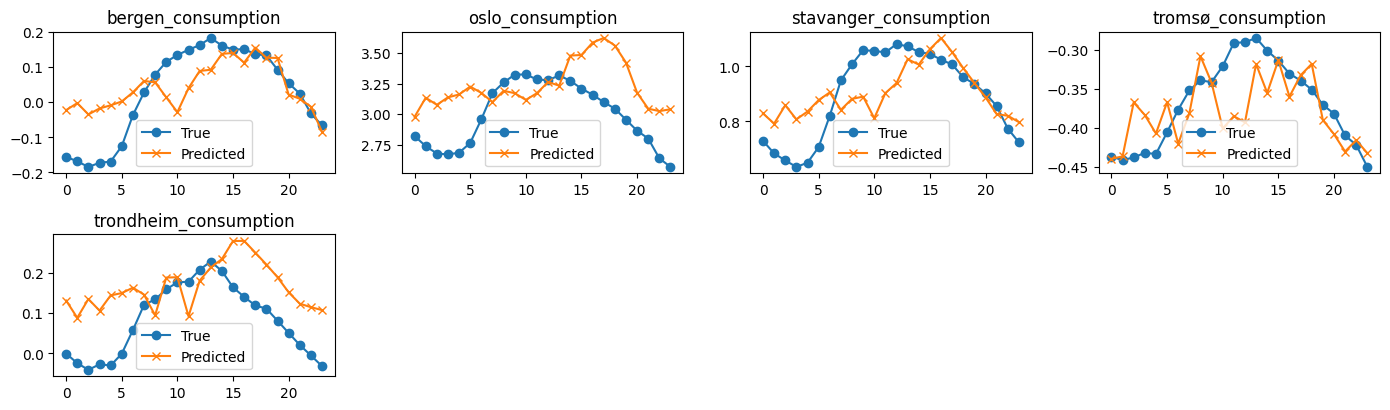

In [ ]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(5):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# Transformer

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, 
                 feature_size=12, 
                 num_layers=1, 
                 num_heads=6, 
                 feedforward_dim=64, 
                 dropout=0.1, 
                 output_size=12):
        super(TimeSeriesTransformer, self).__init__()
        
        self.feature_size = feature_size
        
        self.positional_encoding = nn.Parameter(torch.randn(1, 107, feature_size))
        
        self.transformer = nn.Transformer(d_model=feature_size, 
                                          nhead=num_heads, 
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, 
                                          dim_feedforward=feedforward_dim, 
                                          dropout=dropout)
        
        self.linear = nn.Linear(feature_size, output_size)
        
    def forward(self, x, verbose=False):
        # Add positional encoding
        x = x + self.positional_encoding

        if verbose:
            print('1:', x.shape)
        
        # Transformer expects tgt (target tensor) for supervised tasks, but for our forecasting task
        # We'll use shifted input as target (this is a common trick for time series forecasting)
        tgt = torch.roll(x, shifts=-1, dims=1)

        if verbose:
            print('2:', tgt.shape)
        
        # Apply transformer
        out = self.transformer(x, tgt)

        if verbose:
            print('3:', out.shape)
        
        # Use relevant steps from the transformer output
        out = out[:, GAP_PREDICTION:GAP_PREDICTION+WINDOW_SIZE_Y, :]

        if verbose:
            print('4:', out.shape)
        
        # Pass through linear layer
        out = self.linear(out)

        if verbose:
            print('5:', out.shape)
        
        return out
    
model = TimeSeriesTransformer()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 6704
Trainable parameters: 6704


In [ ]:
model = TimeSeriesTransformer()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12)
out = model(input, verbose=True)

1: torch.Size([25, 107, 12])
2: torch.Size([25, 107, 12])
3: torch.Size([25, 107, 12])
4: torch.Size([25, 24, 12])
5: torch.Size([25, 24, 12])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = TimeSeriesTransformer(dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop with mini-batches
def train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size, epochs):
    model.train()
    
    # Create DataLoader for batching
    dataset = TensorDataset(train_X, train_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = outputs[:,:,:5]
            batch_y = batch_y[:,:,:5]
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(train_X)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs[:,:,:5]
        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size=128, epochs=100)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/100], Loss: 0.0437
Epoch [20/100], Loss: 0.0382
Epoch [30/100], Loss: 0.0344
Epoch [40/100], Loss: 0.0345
Epoch [50/100], Loss: 0.0322
Epoch [60/100], Loss: 0.0298
Epoch [70/100], Loss: 0.0284
Epoch [80/100], Loss: 0.0281
Epoch [90/100], Loss: 0.0267
Epoch [100/100], Loss: 0.0260
Test Loss: 0.0230


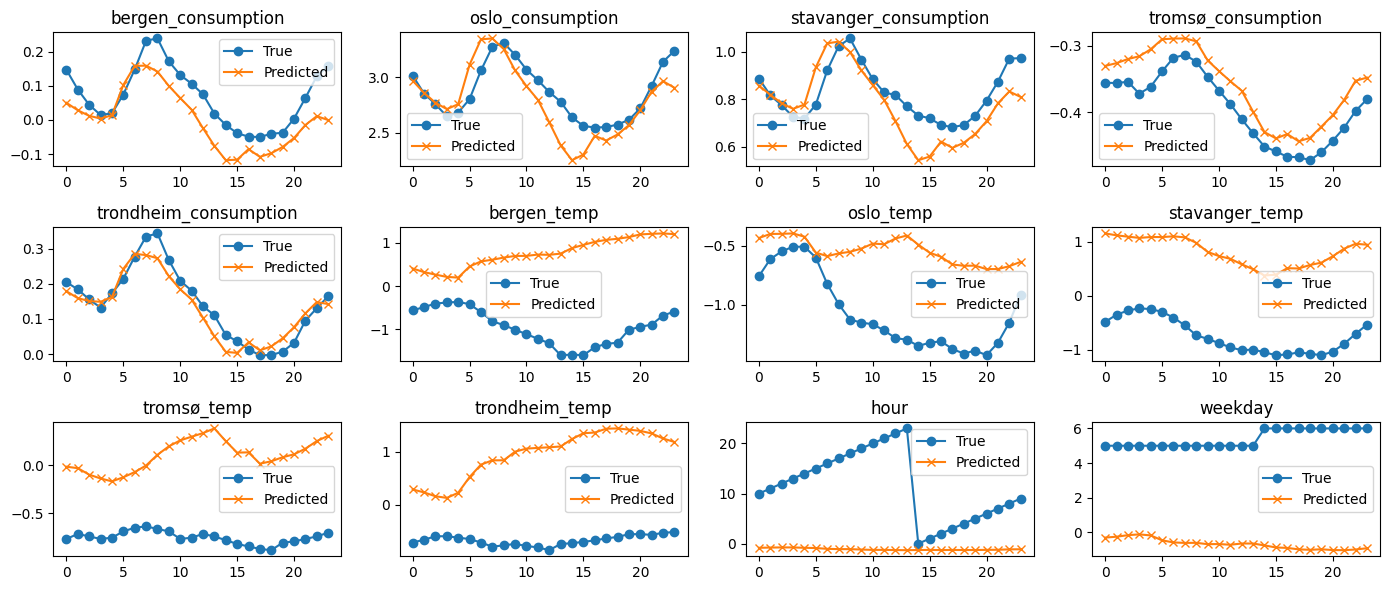

In [ ]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X)

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(12):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# Transformer take 2

In [ ]:
class TransformerForecasting(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, output_dim, n_future):
        super(TransformerForecasting, self).__init__()

        # Embedding layer: This layer converts the input features into embeddings of dimension d_model
        self.embedding = nn.Linear(input_dim, d_model)

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_encoder_layers
        )

        # Output layer: Produces a vector for future time steps
        self.output_layer = nn.Linear(d_model, output_dim * n_future)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(x[:, -1, :])  # Only consider the last time step's output for forecasting
        return x.view(x.size(0), -1)

In [ ]:
# # from trans1
# feature_size=12, 
# num_layers=1, 
# num_heads=6, 
# feedforward_dim=64, 
# dropout=0.1, 
# output_size=12

# # --
# input_dim = 1  # number of features in your input
# d_model = 64  # dimension of the model; traditionally 512, but can be smaller for our purposes
# nhead = 4  # number of attention heads
# num_encoder_layers = 3
# output_dim = 1  # number of features in your output
# n_future = 5  #

In [ ]:
model = TransformerForecasting(12, 64, 2, 3, 5, WINDOW_SIZE_Y+GAP_PREDICTION).to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12, device='cuda')
out = model(input)
print(out.shape)

torch.Size([25, 185])


In [ ]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecasting(12, 64, 2, 3, 5, WINDOW_SIZE_Y+GAP_PREDICTION).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size, epochs):
    model.train()
    
    # Create DataLoader for batching
    dataset = TensorDataset(train_X, train_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]
            batch_y = batch_y[:,:,:5]
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(train_X)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs.view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size=64, epochs=100)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/100], Loss: 0.0233
Epoch [20/100], Loss: 0.0196
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0118
Epoch [60/100], Loss: 0.0107
Epoch [70/100], Loss: 0.0094
Epoch [80/100], Loss: 0.0091
Epoch [90/100], Loss: 0.0077
Epoch [100/100], Loss: 0.0065
Epoch [10/100], Loss: 0.0074
Epoch [20/100], Loss: 0.0061
Epoch [30/100], Loss: 0.0056
Epoch [40/100], Loss: 0.0051
Epoch [50/100], Loss: 0.0051
Epoch [60/100], Loss: 0.0048
Epoch [70/100], Loss: 0.0042
Epoch [80/100], Loss: 0.0040
Epoch [90/100], Loss: 0.0037
Epoch [100/100], Loss: 0.0038
Test Loss: 0.0036


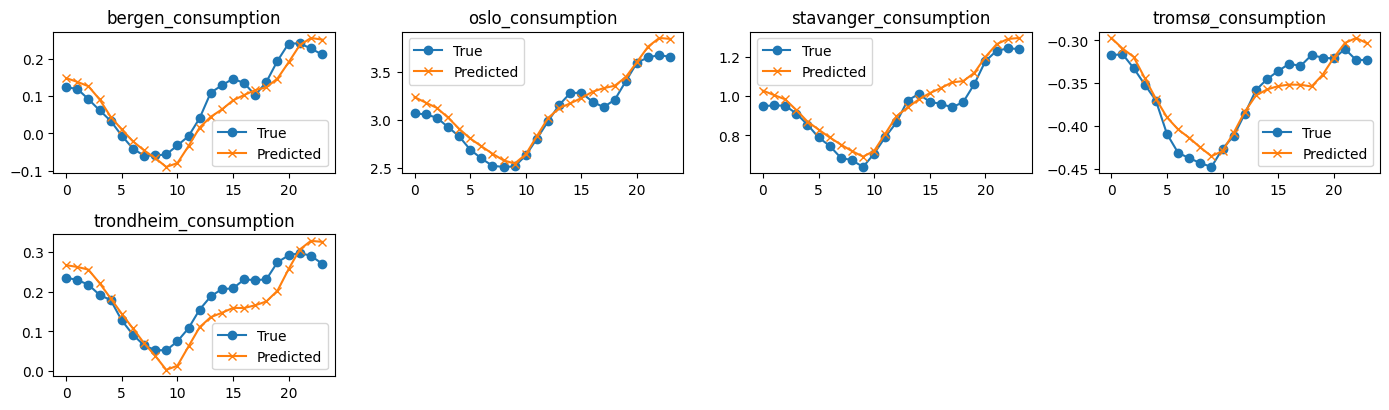

In [ ]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(5):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# TST from paper

In [ ]:
from tsai.all import *

In [ ]:
bs = 64
c_in = 12  # aka channels, features, variables, dimensions
c_out = 5
seq_len = 107

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 256
d_model = 128
n_heads = 6
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
dropout = 0.1
n_layers = 3
fc_dropout = 0.1
kwargs = {}

model = TST(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, n_layers=n_layers,
            fc_dropout=fc_dropout, **kwargs)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 476677


In [ ]:
model(T.rand((10, 12, 107))).shape

torch.Size([10, 5])